In [1]:
%load_ext watermark

In [6]:
%watermark -v -d -a 'Sebastian_Raschka' -p sklearn,matplotlib,numpy,pandas

Sebastian_Raschka 2018-02-05 

CPython 3.5.4
IPython 6.2.1

sklearn 0.19.0
matplotlib 2.1.0
numpy 1.13.3
pandas 0.20.3


In [7]:
%matplotlib inline

세단계로 간단하게 보는 주성분 분석 (PCA)
-----------------------------------

주성분 분석(PCA, Principal Component Analysis)은 단순함에도 수많이 응용되는 (주식 시장 예측이나, 유전자 표현형 데이터 분석 등등) 유용한 선형 변환(linear transformation) 테크닉이다. 튜토리얼에서는 PCA를 3개의 기본 단계로 내부를 풀어볼 것이다.

이 글은 재구성되었으며, 원본도 여전히 [이곳](http://nbviewer.ipython.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/principal_component_analysis.ipynb) 에서 볼 수 있다.

<hr>

섹션
-------------

- [소개](#Introduction)
    - [PCA Vs. LDA](#PCA-Vs.-LDA)
    - [PCA와 차원 축소](#PCA-and-Dimensionality-Reduction)
    - [PCA 접근법 요약](#A-Summary-of-the-PCA-Approach)
- [아이리스 데이터셋 준비](#Preparing-the-Iris-Dataset)
    - [아이리스에 대해](#About-Iris)
    - [데이터셋 로딩](#Loading-the-Dataset)
    - [탐색적 시각화 (Exploratory Visualization)](#Exploratory-Visualization)
    - [표준화 (Standardizing)](#Standardizing)
- [1 - 대각화 분해 (Eigendecomposition) - 고유벡터들과 고유값 계산](#1---Eigendecomposition---Computing-Eigenvectors-and-Eigenvalues)
    - [공분산 행렬 (Covariance Matrix)](#Covariance-Matrix)
    - [상관 행렬 (Correlation Matrix)](#Correlation-Matrix)
    - [특이값 분해 (Singular Vector Decomposition)](#Singular-Vector-Decomposition)
- [2 - 주성분 선택](#2---Selecting-Principal-Components)
    - [고유쌍 분류 (Sorting Eigenpairs)](#Sorting-Eigenpairs)
    - [설명된 분산 (Explained Variance)](#Explained-Variance)
    - [투영 행렬 (Projection Matrix)](#Projection-Matrix)
- [3 - 새로운 특징 공간에 투영하기](#3---Selecting-Principal-Components)
- [지름길 - 사이킷 런의 PCA](#Shortcut---PCA-in-scikit-learn)

<hr>

소개
------------

[[목차로](#Sections)]

현대 데이터의 순전한 크기는 컴퓨터 하드웨어에 대한 도전이자 많은 머신러닝 알고리즘 성능의 주 장애물이다. 

주성분 분석(PCA)의 주요 목적은 데이터의 패턴을 밝혀내는데에 있다; PCA는 변수간의 상관성을 발견하는 걸 노린다. 만약 변수간에 강한 연관성이 있으면, 차원을 축소하려는 시도는 그럴싸하다. 간단히 말하자면, 이것이 PCA의 전부이다: 높은 차원 데이터 내부의 최대 분산 방향을 찾고, 정보의 대부분이 유지되는 동안 더 작은 차원의 부공간에 투영한다.

<br>
<br>

PCA Vs. LDA
-----------------

[[back to top](#Sections)]

선형 판별 분석(LDA, Linear Discriminant Analysis)와 주성분 분석(PCA) 모두 선형 변환 방식이다. PCA는 데이터의 분산을 최대화하는 (주성분의) 방향을 산출하고, LDA도 서로 다른 클래스간의 분리(또는 판별)를 최대화하는 방향을 찾는(패턴 분류 문제에 유용하다, PCA는 클래스의 레이블을 무시한다) 목표이므로 말이다. 
**다른 말로 표현하자면, PCA는 전체 데이터셋을 다른 특징을 가진 (부)공간에 투영하고, LDA는 서로 다른 클래스들에 속한 패턴들간을 분류하기 위해 적합한 특징 (부)공간을 결정하려는 시도이다.**


Both Linear Discriminant Analysis (LDA) and PCA are linear transformation methods. PCA yields the directions (principal components) that maximize the variance of the data, whereas LDA also aims to find the directions that maximize the separation (or discrimination) between different classes, which can be useful in pattern classification problem (PCA "ignores" class labels).   
***In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes.***  

<br>
<br>

PCA와 차원 축소
----------------

[[back to top](#Sections)]

정보의 대부분이 유지되는 동안 계산 효율 증대를 위해, $d$-차원 데이터셋의 차원을 $k$-차원의 부공간 ($k\;<\;d$ 일때)에 투영해서 차원을 축소하는 일이 종종 원하는 목표가 된다. 중요한 질문은 "데이터를 '잘' 대표하는 $k$의 크기가 무엇인가?"라는 것이다.<br>

나중에, 우리는 데이터셋의 고유벡터(주성분)를 계산하고 투영 행렬(Projection Matrix)에서 그들을 모을 것이다. 고유벡터들은 각각 상응하는 고유벡터의 "길이" 또는 "크기"로 변환하는 고유값과 관련이 있다.<br>

만약 일부 고유값들이 다른 것들보다 현저히 큰 크기를 갖고 있다면, 더 작은 차원의 부공간위에 "정보량이 덜한" 고유쌍을 떨어트리는 PCA로 데이터셋을 축소하는 건 합리적인 방법이다.<br>

<br>
<br>

PCA 접근법 요약
--------------

[[back to top](#Sections)]

- 데이터 표준화
- 공분산 행렬(Covariance Matrix), 상관 행렬(Correlation Matrix)로부터 또는 특이값 분해(SVD) 수행으로 고유벡터와 고유값 획득
- $k$개의 커다란 고유값들($k$는 새로운 특징 부공간의 차원 숫자)에 상응하는 고유값 분류와 $k$-고유벡터들  내림차순으로 정렬 ($k \le d$)
- 선택된 $k$ 고유벡터들로부터 투영 행렬 $\mathbf{W}$ 생성
- $\mathbf{W}$를 통해 원본 데이터셋 $\mathbf{X}$를 $k$ 차원의 특징 부공간 $\mathbf{Y}$를 담도록 변환


<br>
<br>

아이리스 데이터셋 준비
-----------------------

아이리스에 대해
--------------

[[back to top](#Sections)]

이어지는 튜토리얼에서, 우리는 UCI 머신러닝 레포에 있는, 유명한 "아이리스" 데이터셋을 다룰 것이다.
([https://archive.ics.uci.edu/ml/datasets/Iris](https://archive.ics.uci.edu/ml/datasets/Iris))


아이리스 데이터셋은 세 종의 아이리스꽃 150개의 측정값이 들어 있다.

아이리스 데이터셋에 있는 세 개의 클래스는:

1. 아이리스-세토사 (n=50)
2. 아이리스-버시컬러 (n=50)
3. 아이리스-버지니카 (n=50)


그리고 아이리스 데이터셋에 있는 네 개의 특징들은:

1. 꽃받침(sepal) 길이 (cm) 
2. 꽃받침(sepal) 넓이 (cm)
3. 꽃잎(petal) 길이 (cm)
4. 꽃잎(petal) 넓이 (cm)<br><br>

<img src="http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/04/iris_petal_sepal.png" height="300" width="200">

<br>

데이터셋 로딩
---------------

[[back to top](#Sections)]

UCI 레포로부터 아이리스 데이터를 직접적으로 로딩하기 위해, 우리는 [판다스](http://pandas.pydata.org) 라이브러리를 사용할 것이다. 만약 판다스를 아직 써본적 없다면, [판다스 튜토리얼](http://pandas.pydata.org/pandas-docs/stable/tutorials.html)을 보기를 권한다.

In [9]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [10]:
# split data table into data X and class labels y

X = df.ix[:,0:4].values
y = df.ix[:,4].values

d:\ana\envs\tf\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
d:\ana\envs\tf\lib\site-packages\pandas\core\indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


아이리스 데이터셋은 이제 150 x 4 행렬의 형태로 저장되었다. 열(columns)들은 다른 특징을 나타내고, 행(rows)들은 분리된 꽃 샘플을 나타낸다. 각 샘플의 행 x는 4 차원의 벡터로 나타낼 수 있다.<br><br>  


$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{꽃받침 길이} \\ \text{꽃받침 넓이} \\\text{꽃잎 길이} \\ \text{꽃잎 넓이} \end{pmatrix}$

<br>
<br>

탐색적 시각화 (Exploratory Visualization)
------------

[[back to top](#Sections)]

어떻게 3개의 서로 다른 꽃 클래스가 4개의 다른 특징들을 따라 분포되는지를 알기 위해, 히스토그램을 통한 시각화를 해보자.

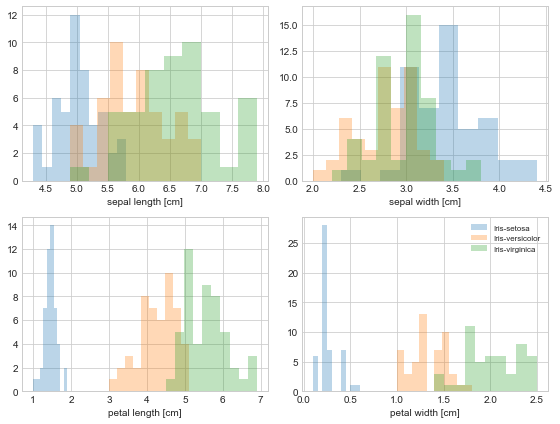

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

<br>
<br>

표준화하기 (Standardizing)
---------------

[[back to top](#Sections)]

PCA를 위해 사전에 데이터를 표준화하든 아니든 공분산 행렬은 원본 특징(original features)의 측정 크기에 달려있다. PCA가 축을 따라 분산을 극대화하는 특징 부공간(feature subspace)을 산출하면, 특히 다른 크기들이 측정되었을 경우, 데이터를 표준화하는게 좋다.

아이리스 데이터셋의 모든 특징들은 cm로 측정되었으나, 많은 머신 러닝 알고리즘들의 궁극의 성능을 위해 요구하듯, 유닛 크기(평균=0 그리고 분산=1)로 데이터를 변환해서 간다.

In [34]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

<br>

1 - 대각화 분해 (Eigendecomposition)<br><br>고유벡터들(Eigenvectors)과 고유값들(Eigenvalues) 계산
---------------------------------------------

[[back to top](#Sections)]

공분산 (또는 상관) 행렬의 고유벡터들과 고유값들은 PCA의 "핵"을 대표한다: 고유벡터들(주성분들)은 새로운 특징 공간의 방향을 결정하며, 고유값들은 그들의 크기를 결정한다. 다른 말로, 고유값들은 새로운 특징 축을 따라 데이터의 분산을 설명한다.

<br>

공분산 행렬 (Covariance Matrix)
---------------

[[back to top](#Sections)]

PCA에 대한 전통적 접근 방식은, 각 요소가 두 특징간의 공분산을 나타내는 $d$ x $d$ 행렬인 공분산 행렬($\Sigma$)의 대각화 분해를 하는 것이다. 두 특징간의 공분산 계산은 아래와 같다:<br><br>

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$<br><br>


행렬 공식을 따라 공분산 행렬의 계산을 요약할 수 있다:<br>

$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  <br><br>
여기서 $\mathbf{\bar{x}}$는 평균 벡터이다   $\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  <br><br>

평균 벡터(mean vector)는, 벡터안의 각 값이 데이터셋 내부 특징 컬럼(feature column)의 샘플 평균을 나타내는 d-차원 벡터이다.

In [13]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [14]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


목적들의 시연을 위해 간단히 사용되는 위보다 더 장황한 길로, 우리는 넘파이의 'cov' 함수를 사용할 수 있다.

The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy `cov` function:

In [15]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


<br>

다음으로, 공분산 행렬의 대각화 분해를 해야 한다:

In [36]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


<br>
<br>

상관 행렬 (Correlation Matrix)
---------------

[[back to top](#Sections)]

특히 "금융" 분야에서, 상관 행렬은 공분산 행렬 대신 일반적으로 사용된다. 하지만 상관 행렬을 표준화된 공분산 행렬처럼 이해할 수 있기에, 공분산 행렬의 대각화 분해는 (만약 입력 데이터가 표준화되었다면) 상관 행렬을 대각화 분해한 것과 같은 결과를 산출한다. 

Especially, in the field of "Finance," the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

<br>

상관 행렬을 기반으로 한 표준화된 데이터의 대각화 분해:

In [17]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.91081808  0.92122093  0.14735328  0.02060771]


<br>

상관 행렬을 기반으로 한 정제되지 않은 데이터의 대각화 분해:

In [18]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.91081808  0.92122093  0.14735328  0.02060771]


<br>

우리는 같은 고유벡터와 고유값 쌍을 산출하는 세가지 접근 방법 모두를 명확하게 알 수 있다.

- 데이터 표준화 이후, 공분산 행렬의 대각화 분해
- 상관 행렬의 대각화 분해
- 데이터 표준화 이후, 상관 행렬의 대각화 분해

<br>
<br>

특이값 분해 (Singluar Vector Decomposition)
--------------

[[back to top](#Sections)]

공분산 또는 상관 행렬의 대각화 분해를 하는 동안, 대부분의 PCA 구현은 연산 효율을 높이기 위해 특이값 분해(SVD, Singular Vector Decomposition)을 수행한다. 결과가 정말로 같다는 걸 확인하기 위해 SVD를 해보자:

In [19]:
u,s,v = np.linalg.svd(X_std.T)
print('Vectors U:\n', u)

Vectors U:
 [[-0.52237162 -0.37231836  0.72101681  0.26199559]
 [ 0.26335492 -0.92555649 -0.24203288 -0.12413481]
 [-0.58125401 -0.02109478 -0.14089226 -0.80115427]
 [-0.56561105 -0.06541577 -0.6338014   0.52354627]]


<br>

2 - 주성분 선택
-----------------

고유쌍 분류 (Sorting Eigenpair)
-----------

[[back to top](#Sections)]

PCA의 일반적인 목표는 더 작은 부공간(고유벡터들이 축의 형태일)으로 투영하는 일을 통해 원본 특징 공간의 차원을 줄이는 것이다. 그러나 유닛 길이가 1로 모두 같은 이후로, 고유벡터들은 새로운 축의 방향으로만 정의된다. 아래 두 줄의 코드를 통해 확인할 수 있다. <br><br>
The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [32]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


<br>

낮은 차원의 부공간 구조에서 너무 많은 정보를 잃어버리는 일 없이, 어떤 고유벡터(들)을 떨어트릴지 결정하기 위해, 해당하는 고유값들을 살펴볼 필요가 있다: 데이터의 분포에 관해 최소한의 정보만 갖고 있는, 가장 낮은 고유값들을 가진 고유벡터들; 이런 녀석들을 떨어트릴 수 있다. 

흔한 접근방법은 고유값들의 순위를 매기는 것이다. 가장 높은 것부터 가장 낮은 것까지 차례로 $k$개의 고유 벡터들을 선택한다.

In [35]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.91081808375
0.921220930707
0.147353278305
0.0206077072356


<br>

설명된 분산 (Explained Variance)
-----------------

[[back to top](#Sections)]

고유쌍을 분류한 뒤, 그 다음 질문은 "새로운 특징 부공간을 위해 얼마나 많은 주성분들을 선택해야 하나?"이다. 유용한 측정 방법은 이른바 "설명된 분산(explained variance)", 고유값으로부터 계산할 수 있다. 설명된 분산은 얼마나 많은 정보(분산)가 주성분들 각각의 속성일 수 있나를 말해준다.

In [24]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Sebastian/Desktop/pca2.pdf'

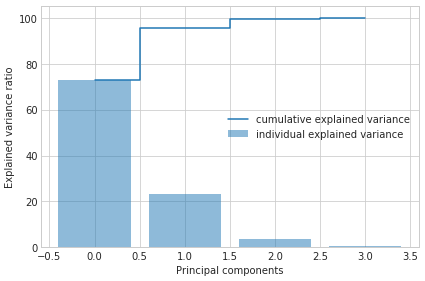

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('/Users/Sebastian/Desktop/pca2.pdf')

위의 플롯은 분산의 대부분(분산의 72.77%는 명확하다.)을 첫번째 주성분 만으로 설명할 수 있다는 걸 명확하게 보여준다. 세번째와 네번째 주성분들이 많은 정보를 잃어버리는 일 없이 안전하게 떨어지는 와중에도, 두번째 주성분은 여전히 약간의 정보(23.03%)를 담고 있다. 합쳐보면 처음의 두 주성분은 95.8%의 정보를 갖고 있다. 

<br>

투영 행렬 (Projection Matrix)
---------------

[[back to top](#Sections)]

정말로 흥미로운 부분을 할 시간이다 : 투영 행렬의 구조로 아이리스 데이터를 새로운 특징 부공간위로 변환하는데에 사용할 수 있다. 이름인 "투영 행렬"이 좋게 들리지만, 기본적으로 상위 *k* 고유값들이 이어진 행렬일 뿐이다.<br>

$d \times k$-차원의 고유벡터 행렬 $\mathbf{W}$를 구성하려 가장 높은 고유값들을 가진 "상위 2개의" 고유벡터들을 선택함으로써, 4차원의 특징 공간을 2차원의 특징 부공간으로 축소한다.

In [26]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


<br>
<br>

3 - 새로운 특징 공간에 투영하기
--------------------------------

[[back to top](#Sections)]

마지막 단계에서 우리는 ($4 \times 2$)-차원의 투영 행렬 $\mathbf{W}$를 공식 $\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$를 통해 새로운 부공간위로 샘플들을 변환하는데 사용할 수 있다. $\mathbf{Y}$는 변환된 샘플의 ($150\times 2$) 행렬이다.

In [27]:
Y = X_std.dot(matrix_w)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Sebastian/Desktop/pca1.pdf'

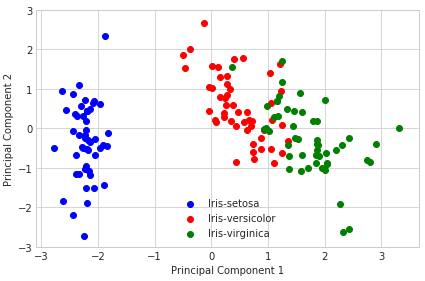

In [28]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()

    plt.savefig('/Users/Sebastian/Desktop/pca1.pdf')

<br>
<br>
<a name="mat_pca"></a>

<br>
<a name="sklearn_pca"> </a>

지름길 - 사이킷런의 PCA
----------------------

[[back to top](#Sections)]

교육을 목적으로, 우리는 아이리스 데이터셋에 PCA를 적용하기 위한 긴 여정을 했다. 다행히 사이킷 런에 이미 (PCA가) 구현되어 있다.

In [30]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

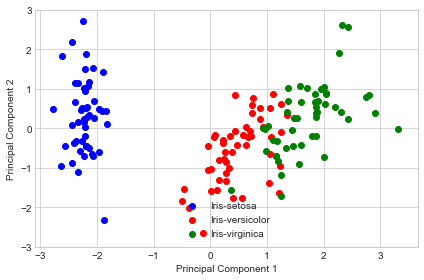

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()